In [ ]:
import torch
from srm import SRMBlock
from linear_gating import LinearGating

# Set print formatting for readability
torch.set_printoptions(linewidth=200)

# Test case 1: 4x4 input with window_size=2
dummy_input = torch.arange(1, 17).reshape(1, 1, 4, 4).float()
print("Test Case 1 - 4x4 input, window_size=2")
print("Input:")
print(dummy_input)

# Test srm block
srm_block = SRMBlock(window_size=2, step_size = 1, in_channels=1, original_height=4, original_width=4)
out = srm_block(dummy_input)
print("\nOutput SRM block:")
print(out)

lg = LinearGating(dim=out.shape[1], use_activation=False)
out_gated = lg(out)
print("\nOutput LG:")
print(out_gated)

with torch.no_grad():
    B, C, H, W = out.shape
    x_reshaped = out.view(B, C, H * W).permute(0, 2, 1)
    gates = lg.fc(x_reshaped)
    print("\nGating values before multiply:")
    print(gates.view(B, C, H, W))


In [1]:
import os
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as T
from srm import SRMBlock
from linear_gating import LinearGating

# Load Input Blurry Image
load_dir = './Datasets/train/GoPro/input_crops'
name = '000002-5'
img_path = os.path.join(load_dir, name + '.png')

# Load full RGB image (H, W, 3)
input_img = plt.imread(img_path)
print("Loaded shape:", input_img.shape)  # Should be (256, 256, 3)

# Convert to tensor: (1, 3, H, W)
transform = T.Compose([
    T.ToTensor(),  # Converts to [0, 1], shape (C, H, W)
])

input_tensor = transform(input_img).unsqueeze(0)  # → shape: (1, 3, 256, 256)

print("Tensor shape for SRM:", input_tensor.shape)

srm_block = SRMBlock(window_size=4, step_size=2, in_channels=3, original_height=256, original_width=256)
output_s2 = srm_block(input_tensor)

print("SRM Output Shape:", output_s2.shape)

srm_block = SRMBlock(window_size=4, step_size=4, in_channels=3, original_height=256, original_width=256)
output_s4 = srm_block(input_tensor)

print("SRM Output Shape:", output_s4.shape)

'''
# Initialize gating module with correct channel size
gating = LinearGating(dim=output.shape[1], use_activation=False)  # or True if you want sigmoid mask
# ADD THIS BLOCK right here to initialize to identity
with torch.no_grad():
    gating.fc.weight.copy_(torch.eye(3))
    gating.fc.bias.zero_()
'''
# Apply Linear Gating
dim = output_s2.shape[1]
gating = LinearGating(dim=dim, use_activation=False)

# Optional: initialize to identity
with torch.no_grad():
    gating.fc.weight.copy_(torch.eye(dim))
    gating.fc.bias.zero_()

gated_output = gating(output_s2)

Loaded shape: (256, 256, 3)
Tensor shape for SRM: torch.Size([1, 3, 256, 256])

After width padding:
tensor([[1.0000, 1.0000, 1.0000,  ..., 0.1804, 0.1725, 0.1804],
        [1.0000, 1.0000, 1.0000,  ..., 0.1765, 0.1725, 0.1765],
        [1.0000, 1.0000, 1.0000,  ..., 0.1725, 0.1686, 0.1725],
        ...,
        [0.0706, 0.0706, 0.0706,  ..., 0.1373, 0.1451, 0.1373],
        [0.0667, 0.0667, 0.0667,  ..., 0.1412, 0.1490, 0.1412],
        [0.0627, 0.0627, 0.0627,  ..., 0.1490, 0.1529, 0.1490]])
IDX MISSING:  1
IDX MISSING:  128
IDX MISSING:  1
IDX MISSING:  128
SRM Output Shape: torch.Size([1, 3, 256, 256])

After width padding:
tensor([[1.0000, 1.0000, 1.0000,  ..., 0.1686, 0.1725, 0.1804],
        [1.0000, 1.0000, 1.0000,  ..., 0.1686, 0.1725, 0.1765],
        [1.0000, 1.0000, 1.0000,  ..., 0.1686, 0.1686, 0.1725],
        ...,
        [0.0706, 0.0706, 0.0706,  ..., 0.1451, 0.1451, 0.1373],
        [0.0667, 0.0667, 0.0667,  ..., 0.1529, 0.1490, 0.1412],
        [0.0627, 0.0627, 0.0627

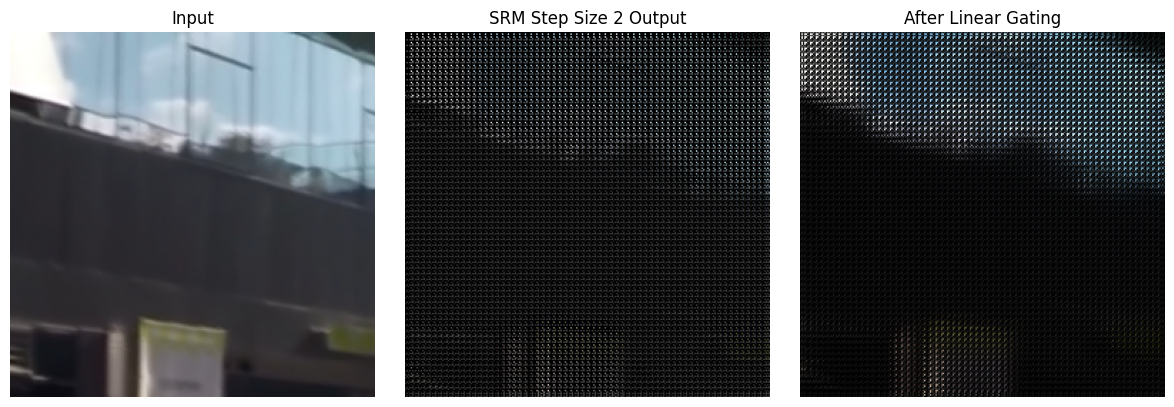

In [3]:
to_pil = T.ToPILImage()

# Remove batch dimension and clamp to [0,1] for display
input_img_vis = to_pil(input_tensor.squeeze(0).clamp(0, 1))
output_img_vis = to_pil(output_s2.squeeze(0).clamp(0, 1))
output_s4_img_vis = to_pil(output_s4.squeeze(0).clamp(0, 1))

gated_img_vis = to_pil(gated_output.squeeze(0).clamp(0, 1))

# Show them side-by-side
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(input_img_vis)
axs[0].set_title("Input")
axs[1].imshow(output_img_vis)
axs[1].set_title("SRM Step Size 2 Output")
'''
axs[2].imshow(output_s4_img_vis)
axs[2].set_title("SRM Step Size 4 Output")
'''
axs[2].imshow(gated_img_vis)
axs[2].set_title("After Linear Gating")

for ax in axs: ax.axis('off')
plt.tight_layout()
plt.show()

#print("SRM min/max:", output_s4.min().item(), output.max().item())


In [ ]:
import matplotlib.pyplot as plt

channels = output.squeeze(0)  # shape [3, H, W]

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    axs[i].imshow(channels[i].detach().cpu().numpy(), cmap='gray')
    axs[i].set_title(f"SRM Channel {i}")
    axs[i].axis('off')
plt.tight_layout()
plt.show()